In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/mpf/Sites/OPT-blog/posts/epsilon-rank"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| echo: false
#| output: false
import Pkg
Pkg.activate(".");

  Activating project at `~/Sites/OPT-blog/posts/epsilon-rank`


In [3]:
using Random
Random.seed!(314159)

m, n, r = 9, 9, 4

X = randn(m, r)
Y = randn(r, n)
A = 5 * (X * Y);

In [4]:
Z = randn(m, n);

In [5]:
using LinearAlgebra

sv_A = svdvals(A)

# Ignore very small singular values since they are numerical noise
cutoff = sqrt(eps())
sv_A[sv_A .<= cutoff] .= 0

sv_Z = svdvals(Z)

9-element Vector{Float64}:
 5.195747512378081
 4.430165084794979
 3.327608957237619
 2.5628256338133104
 1.871076425706428
 1.6860385062230678
 1.34298344860651
 0.6856107065962023
 0.5198723054750027

In [6]:
@show minimum(sv_A[sv_A .!= 0])
@show maximum(sv_Z)

# Is the theorem hypothesis satisfied?
@show maximum(sv_Z) < minimum(sv_A[sv_A .!= 0])/2;

minimum(sv_A[sv_A .!= 0]) = 17.783732331976836
maximum(sv_Z) = 5.195747512378081
maximum(sv_Z) < minimum(sv_A[sv_A .!= 0]) / 2 = true


In [7]:
Y = A + Z

sv_AZ = svdvals(Y)

@show sv_AZ;

sv_AZ = [60.24268959472193, 35.524995726152234, 25.783213945412566, 19.971605650483106, 2.352051795110918, 1.9113966650100234, 1.7478609170716963, 0.3819271402800188, 0.05857415754790129]


In [8]:
function erank(A, ϵ=1; σ=svdvals(A))
    return count(σ .> ϵ)
end

ϵ = sqrt(m) + sqrt(n) + 2
r_estimate = erank(Y, ϵ)

@show r_estimate

@show r == r_estimate;

r_estimate = 4
r == r_estimate = true


   Resolving package versions...


  No Changes to `~/Sites/OPT-blog/posts/epsilon-rank/Project.toml`
  No Changes to `~/Sites/OPT-blog/posts/epsilon-rank/Manifest.toml`


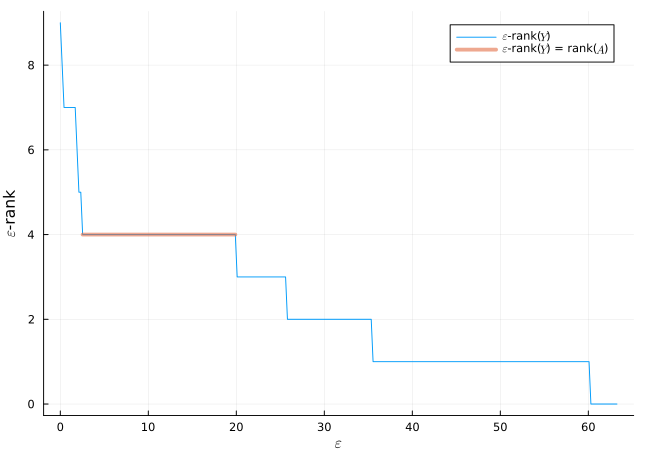

In [9]:
import Pkg
Pkg.add("Plots")
using Plots

N = 300
x = range(0,maximum(svdvals(Y))*1.05, length=N)
σ = svdvals(Y) # compute singular values once
y = [erank(Y, xi; σ) for xi in x]

p = plot(x, y; label="\$\\epsilon\$-rank(\$Y\$)")
xlabel!("\$\\epsilon\$")
ylabel!("\$\\epsilon\$-rank")

a = findfirst(y .== r)
b = findlast(y .== r)

plot!(x[[a, b]], [r, r];
  label="\$\\epsilon\$-rank(\$Y\$) = rank(\$A\$)",
  linewidth=4,
  alpha= 0.6)
display(p)

In [10]:
@show (x[a], x[b]);

(x[a], x[b]) = (2.5386551468009912, 19.88613198327443)


In [11]:
lower, upper = sqrt(m) + sqrt(n), minimum(sv_A[sv_A .!= 0])/2
@show (lower, upper);

(lower, upper) = (6.0, 8.891866165988418)


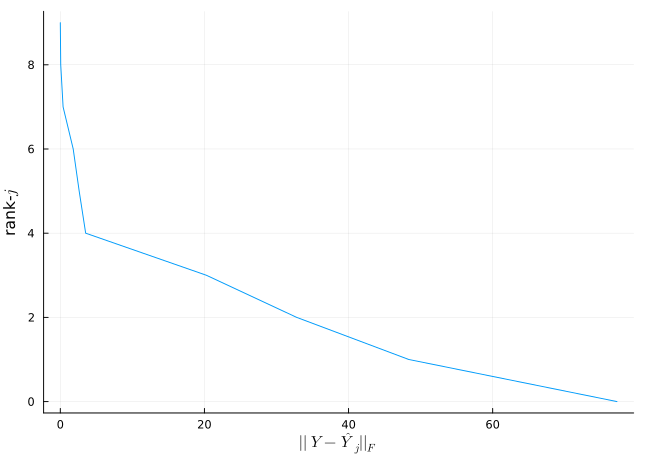

In [12]:
k = min(m,n)
y = [(sum(σ[j+1:end] .^ 2))^(0.5) for j in 0:k]
p = plot(y, 0:k; legend=false)
xlabel!("\${||} Y - \\hat{Y}_j {||} _F\$")
ylabel!("rank-\$j\$")
display(p)

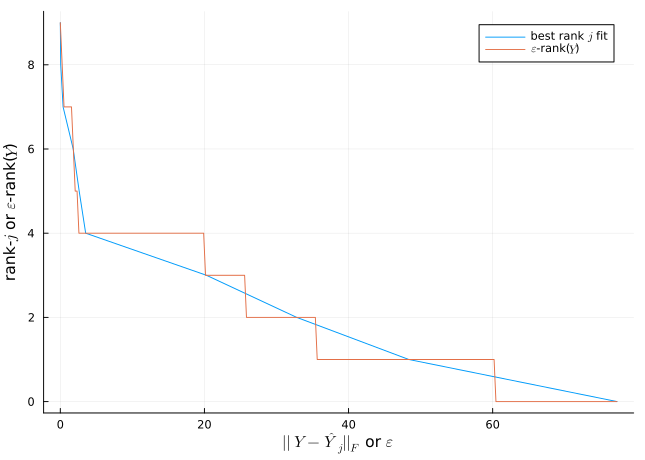

In [13]:
p = plot(y, 0:k; label="best rank \$j\$ fit")
x = range(0, maximum(y), length=N)
plot!(x, [erank(Y, xi; σ) for xi in x]; label="\$\\epsilon\$-rank(\$Y\$)")

xlabel!("\${||} Y - \\hat{Y}_j {||} _F\$ or \$\\epsilon\$")
ylabel!("rank-\$j\$ or \$\\epsilon\$-rank(\$Y\$)")

display(p)

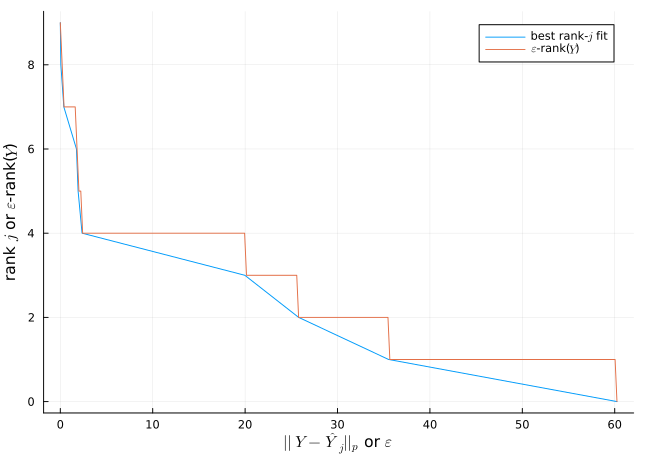

In [14]:
p=20
y = [(sum(σ[j+1:end] .^ p))^(1/p) for j in 0:k]
p = plot(y, 0:k; label="best rank-\$j\$ fit")
x = range(0, maximum(y), length=N)
plot!(x, [erank(Y, xi; σ) for xi in x]; label="\$\\epsilon\$-rank(\$Y\$)")

xlabel!("\${||} Y - \\hat{Y}_j {||} _p\$ or \$\\epsilon\$")
ylabel!("rank \$j\$ or \$\\epsilon\$-rank(\$Y\$)")

display(p)